Calculate Single PSF

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os, sys

# Add project base directory to system path
base_dir = os.path.dirname(os.getcwd())
sys.path.append(base_dir)
from src.psf import calc_psf 

# ---------------------------
# Configuration
# ---------------------------
N = 3000                            # Number of pixels (3000 x 3000)
sensor_size = 3e-3                  # Sensor size in meters
pixel_size = sensor_size / N        # Pixel size in meters
wavelength = 0.5                    # Wavelength in micrometers (um)
focal_length = 5e-3                 # Focal length in meters
z = 5.0                             # Propagation distance in millimeters
sensor_res = sensor_size / pixel_size  # Sensor resolution



In [2]:
# Define Coordinate System
x = torch.linspace(-sensor_size/2, sensor_size/2, N, dtype=torch.float64)
y = torch.linspace(-sensor_size/2, sensor_size/2, N, dtype=torch.float64)
X, Y = torch.meshgrid(x, y, indexing='ij')


# Initialize Incident Plane Wave
U_incident = torch.ones((N, N), dtype=torch.complex128)  # Uniform plane wave


# Compute Phase Modulation for Metalens
k = 2 * torch.pi / (wavelength * 1e-6)              # Wave number
phase = - (k / (2 * focal_length)) * (X**2 + Y**2)  # Quadratic phase profile


# Compute PSF
psf_result = calc_psf(U_incident, phase, wavelength, z, sensor_res, pixel_size)
print("PSF Result Shape:", psf_result.shape)


PSF Result Shape: torch.Size([201, 201])


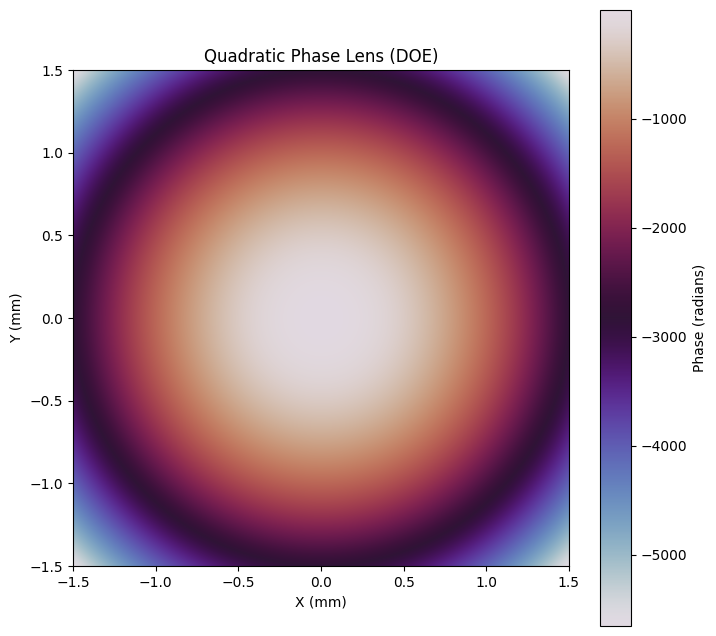

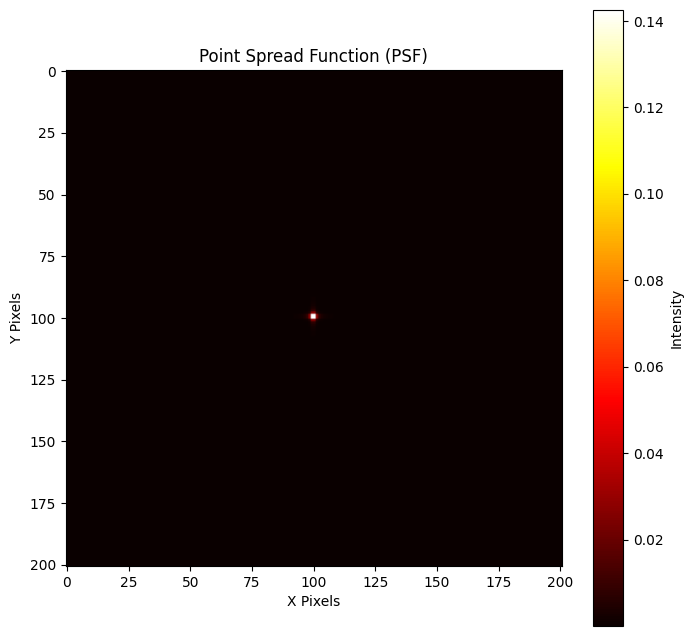

In [3]:

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(phase, cmap='twilight', extent=[-1.5, 1.5, -1.5, 1.5])  # Display phase profile
plt.colorbar(label="Phase (radians)")
plt.title("Quadratic Phase Lens (DOE)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(psf_result, cmap='hot')  # Display PSF result
plt.colorbar(label="Intensity")
plt.title("Point Spread Function (PSF)")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()


Render RGB

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from src.psf import calc_psf
from src.render_PSF import render_psf

# Load the image and convert it to a tensor
def load_image(image_path):
    """
    Returns
        torch.Tensor: Image tensor with shape [1, C, H, W].
    """
    img = Image.open(image_path).convert("RGB")
    img = np.array(img) / 255.0  # Normalize pixel values to [0,1]
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Shape [1, C, H, W]
    return img_tensor

image_path = "../data/1.jpg"  
img_tensor = load_image(image_path)
B, C, H, W = img_tensor.shape


# Compute the PSF for the three RGB channels
N = 3000                            
sensor_size = 3e-3                   
pixel_size = sensor_size / N          
focal_length = 5e-3                   
z = 5.0                               
sensor_res = sensor_size / pixel_size  

# Define wavelengths for RGB channels (in micrometers)
wavelengths = [0.65, 0.55, 0.45]  # (R, G, B)

# Compute PSF for each channel
psf_list = []
for wl in wavelengths:
    k = 2 * torch.pi / (wl * 1e-6)  
    x = torch.linspace(-sensor_size/2, sensor_size/2, N, dtype=torch.float64)
    y = torch.linspace(-sensor_size/2, sensor_size/2, N, dtype=torch.float64)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    
    # Quadratic phase modulation
    phase = - (k / (2 * focal_length)) * (X**2 + Y**2)  
    
    # Compute PSF using the given function
    psf = calc_psf(torch.ones((N, N), dtype=torch.complex128), phase, wl, z, sensor_res, pixel_size)
    psf_list.append(psf)

psf_rgb = torch.stack(psf_list, dim=0)  # Shape: [C, ks, ks]

# Apply PSF to the image
img_render = render_psf(img_tensor, psf_rgb)


# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_render.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap="hot")
plt.title("Rendered Image with PSF")

plt.show()
